In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time

%matplotlib inline

import difi
from difi import __version__
print("difi version: {}".format(__version__))

difi version: 1.1.dev40+gc5afefd


In [2]:
DATA_DIR = "../data"

In [3]:
observations = pd.read_csv(
    os.path.join(DATA_DIR, "observations.txt"), 
    index_col=False, 
    sep=" "
)

all_linkages = pd.read_csv(
    os.path.join(DATA_DIR, "all_linkages.txt"), 
    index_col=False, 
    sep=" "
)

linkage_members = pd.read_csv(
    os.path.join(DATA_DIR, "linkage_members.txt"), 
    index_col=False, 
    sep=" "
)

all_truths = pd.read_csv(
    os.path.join(DATA_DIR, "all_truths.txt"), 
    index_col=False, 
    sep=" "
)

summary = pd.read_csv(
    os.path.join(DATA_DIR, "summary.txt"), 
    index_col=False, 
    sep=" "
)

In [4]:
classes = {
    "NEOs" : observations[observations["obj_id"].str.contains("^S0", regex=True)]["obj_id"].unique(),
    "MBAs" : observations[observations["obj_id"].str.contains("^S1", regex=True)]["obj_id"].unique(),
    "Trojans" : observations[observations["obj_id"].str.contains("^St5", regex=True)]["obj_id"].unique(),
    "Scattered Disk" : observations[observations["obj_id"].str.contains("^SS", regex=True)]["obj_id"].unique(),
    "TNOs" : observations[observations["obj_id"].str.contains("^ST", regex=True)]["obj_id"].unique(),
    "SR" : observations[observations["obj_id"].str.contains("^SR", regex=True)]["obj_id"].unique(),
}

obj_ids = []
for c, o in classes.items():
    obj_ids.append(o)

obj_ids = np.concatenate(obj_ids)
# Make sure all objects are accounted for
assert len(observations[~observations["obj_id"].isin(obj_ids)]) == 0
assert len(obj_ids) == observations["obj_id"].nunique()

In [5]:
column_mapping = {
    "obs_id" : "obs_id",
    "truth" : "obj_id",
    "time" : "mjd_utc",
    "night" : "night",
    "linkage_id" : "trkSub"
}

In [6]:
S3M_orbits = sorted(glob.glob(os.path.join(DATA_DIR, "S3M_v09.05.15", "*.s3m")))

In [7]:
orbits = []

for f in S3M_orbits:
    df = pd.read_csv(
        f, 
        delim_whitespace=True,
        header=1
    )
    df["file"] = [os.path.basename(f) for i in range(len(df))]
    orbits.append(df)
    
orbits = pd.concat(orbits)
orbits.reset_index(
    inplace=True,
    drop=True
)

orbits["a"] = orbits["q"] / (1-orbits["e"])
orbits.loc[orbits["S3MID"].isna(), "S3MID"] = orbits[orbits["S3MID"].isna()]["OID"].values
orbits.drop(
    columns=["OID"],
    inplace=True
)

assert orbits["S3MID"].nunique() == len(orbits)

In [8]:
orbits = orbits[orbits["S3MID"].isin(observations["obj_id"].unique())]

In [9]:
findable = all_truths[all_truths["findable"] == 1]["obj_id"].unique()
not_findable = all_truths[~all_truths["obj_id"].isin(findable)]["obj_id"].unique()

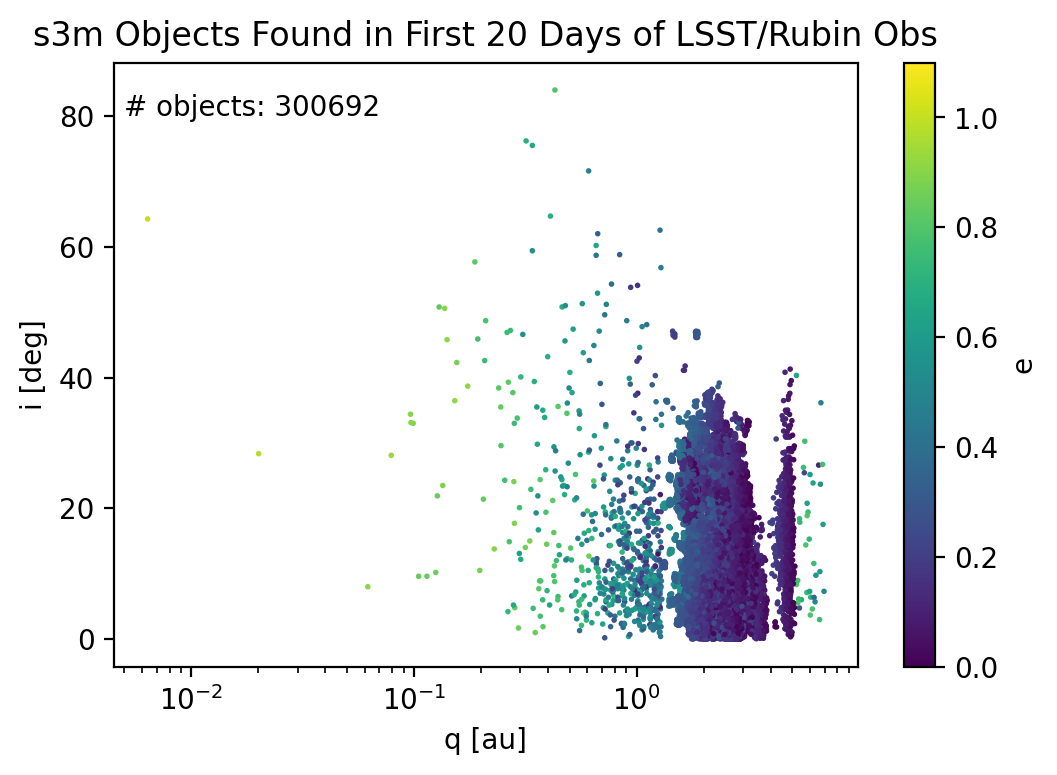

In [10]:
fig, ax = plt.subplots(1, 1, dpi=200)
cm = ax.scatter(
    *orbits[orbits["S3MID"].isin(findable)][["q", "i"]].values.T, 
    c=orbits[orbits["S3MID"].isin(findable)]["e"].values,
    s=1,
    vmin=0,
    vmax=1.1,
)
ax.set_xlabel("q [au]")
ax.set_ylabel("i [deg]")
ax.set_xscale("log")
ax.set_title("s3m Objects Found in First 20 Days of LSST/Rubin Obs")
cb = fig.colorbar(cm)
cb.set_label("e")
ax.text(0.005, 80, "# objects: {}".format(len(findable)))
fig.savefig(
    "orbit_distribution_logqie_20days.png",
    bbox_inches="tight"
)

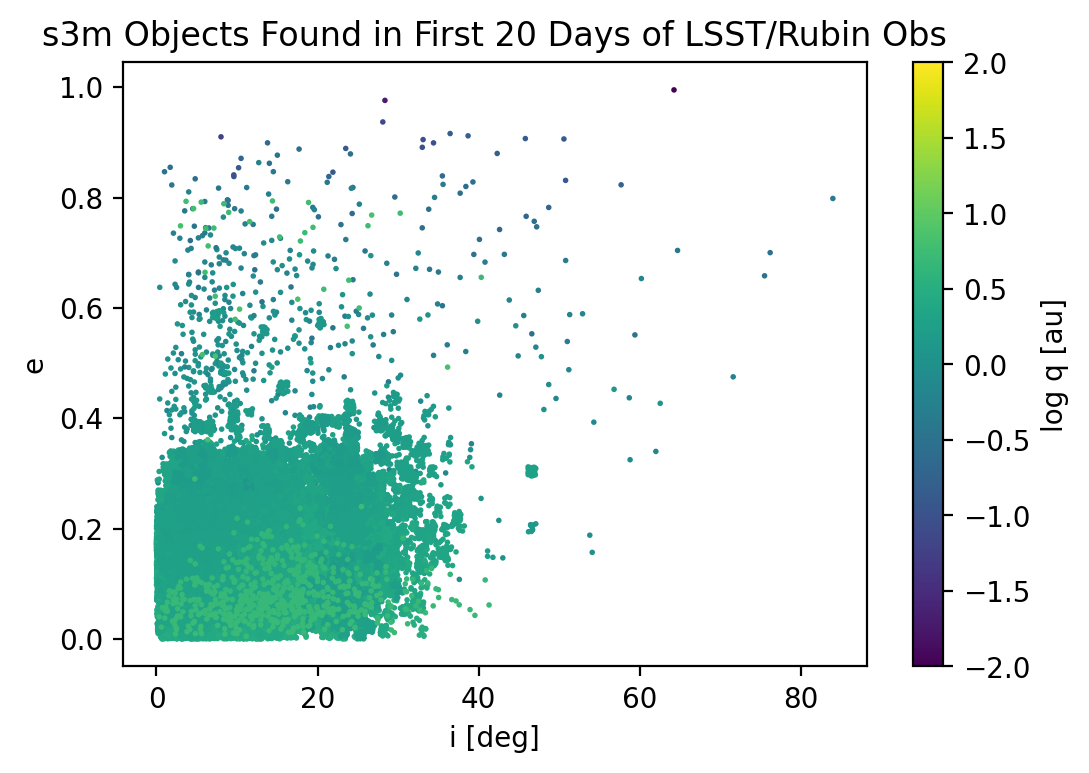

In [11]:
fig, ax = plt.subplots(1, 1, dpi=200)
cm = ax.scatter(
    *orbits[orbits["S3MID"].isin(findable)][["i", "e"]].values.T, 
    c=np.log10(orbits[orbits["S3MID"].isin(findable)]["q"].values),
    s=1,
    vmin=-2,
    vmax=2,
)
ax.set_xlabel("i [deg]")
ax.set_ylabel("e")
ax.set_title("s3m Objects Found in First 20 Days of LSST/Rubin Obs")
cb = fig.colorbar(cm)
cb.set_label("log q [au]")
fig.savefig(
    "orbit_distribution_ielogq_20days.png",
    bbox_inches="tight"
)

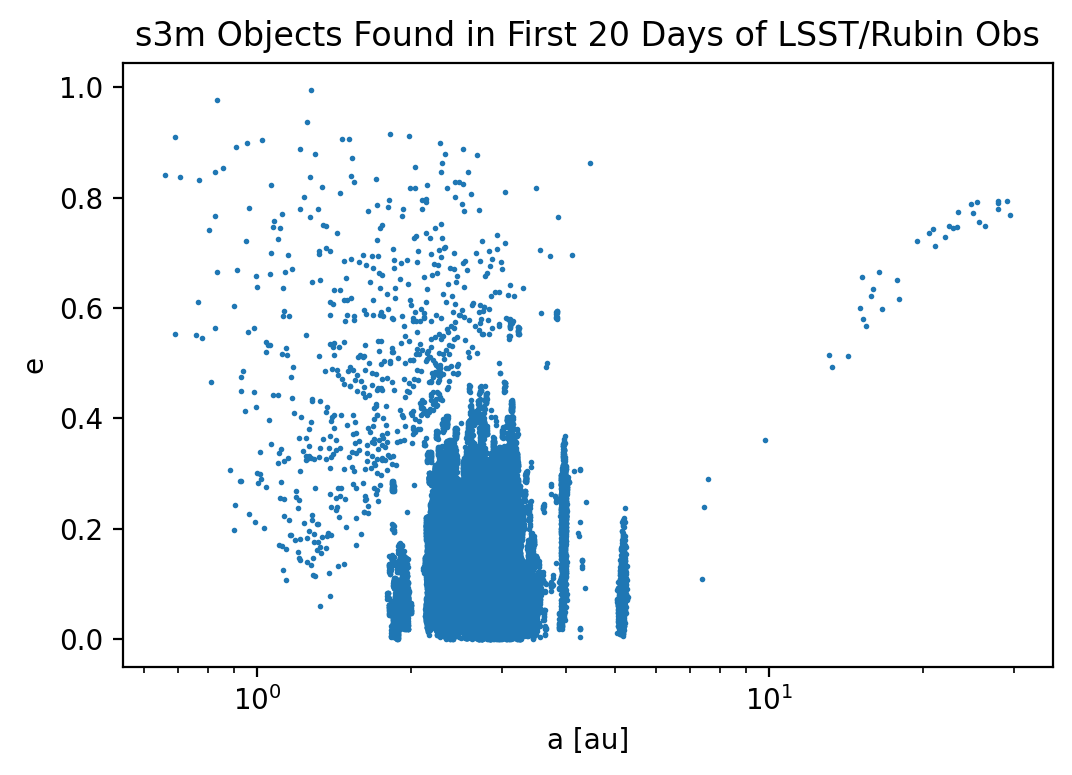

In [12]:
fig, ax = plt.subplots(1, 1, dpi=200)
cm = ax.scatter(
    *orbits[orbits["S3MID"].isin(findable)][["a", "e"]].values.T, 
    s=1,
)
ax.set_xlabel("a [au]")
ax.set_ylabel("e")
ax.set_xscale("log")
ax.set_title("s3m Objects Found in First 20 Days of LSST/Rubin Obs")
fig.savefig(
    "orbit_distribution_logae_20days.png",
    bbox_inches="tight"
)